# SCUFFED 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transform
import torchvision.models as models
from torchvision.datasets import ImageFolder

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt 

KeyboardInterrupt: 

In [ ]:

def mean_std(loader):
  chan_sum, chan_square_sum, num_batches = 0, 0, 0
  for data, _ in loader:
    chan_sum += torch.mean(data, dim=[0, 2, 3])
    chan_square_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
  mean = chan_sum / num_batches
  std = (chan_square_sum/num_batches - mean**2)**.5
  return mean, std

In [ ]:
composed_tr = transform.Compose([transform.Resize((224, 224)),  transform.ToTensor()])
composed_te = transform.Compose([transform.Resize((224, 224)),  transform.ToTensor()])

In [ ]:
train_data = ImageFolder('data/train', transform=composed_tr)
test_data = ImageFolder('data/val', transform=composed_te)

In [ ]:
train_data.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
#plt.imshow(train_data[253][0].permute(2,1,0)),train_data[8000][1]

In [ ]:
train_load = DataLoader(train_data, batch_size=16, shuffle=True)
test_load = DataLoader(test_data, batch_size=16)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Thu Dec 15 13:13:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   65C    P2    47W / 160W |   4208MiB /  6144MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = models.efficientnet_b3()

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
#for p in model.parameters():
#  p.requires_grad = False

In [ ]:
model.fc = nn.Linear(1536, 2)

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
len(train_load)

10

In [ ]:
len(train_data)/32

4.625

In [ ]:
len(test_load)

3

In [ ]:

epochs = 10



for epoch in range(epochs):
  loss_scores_train = []
  loss_scores_val = []

  correct_train = 0
  num_samp_train = 0
  correct_val = 0
  train_loss = 0
  test_loss = 0
  num_samp_val = 0

  print(f'epoch: {epoch+1} \n--------------------------------')
  for batch, (X, y) in enumerate(train_load):
    X, y = X.to(device), y.to(device)
    model.train()
    
    pred = model(X)
    loss = loss_fn(pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    
    train_loss += loss
    correct_train += (pred.argmax(1) == y).sum().item()
    num_samp_train += pred.shape[0]

    if batch % 32 == 0:
      print(f'loss: {loss.item():.8f} | [{batch*len(X):05d}/{len(train_load.dataset)}]')

  loss_scores_train.append(train_loss/len(train_load))

  print(f'train error: correct: {correct_train}/{num_samp_train} | avgloss: {train_loss/len(train_load):.8f} | acc: {(correct_train/num_samp_train)*100:.2f}')

  model.eval()
  with torch.no_grad():
    for X, y in test_load:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      test_loss += loss
      correct_val += (pred.argmax(1) == y).sum().item()
      num_samp_val += pred.shape[0]
  print(f'test error: correct: {correct_val}/{len(test_load.dataset)} | avgloss: {test_loss/len(test_load):.8f} | acc: {correct_val/len(test_load.dataset)*100:.2f}%')
  
  loss_scores_val.append(test_loss/len(test_load)) 


epoch: 1 
--------------------------------
loss: 6.88801050 | [00000/148]
train error: correct: 89/148 | avgloss: 4.51264048 | acc: 60.14
test error: correct: 20/40 | avgloss: 4.53648567 | acc: 50.00%
epoch: 2 
--------------------------------
loss: 1.43649113 | [00000/148]
train error: correct: 120/148 | avgloss: 1.40173244 | acc: 81.08
test error: correct: 20/40 | avgloss: 1.30052638 | acc: 50.00%
epoch: 3 
--------------------------------
loss: 0.26570058 | [00000/148]
train error: correct: 127/148 | avgloss: 0.51105613 | acc: 85.81
test error: correct: 20/40 | avgloss: 0.85907257 | acc: 50.00%
epoch: 4 
--------------------------------
loss: 0.24568997 | [00000/148]
train error: correct: 120/148 | avgloss: 0.40464345 | acc: 81.08
test error: correct: 20/40 | avgloss: 0.69397199 | acc: 50.00%
epoch: 5 
--------------------------------
loss: 0.48740229 | [00000/148]
train error: correct: 131/148 | avgloss: 0.27365658 | acc: 88.51
test error: correct: 20/40 | avgloss: 0.68722671 | acc

In [ ]:
torch.save(model.state_dict(), "covid_model.pth")

In [ ]:
model_s = model.load_state_dict(torch.load("covid_model.pth"))

In [ ]:
from PIL import Image

In [ ]:
img = Image.open('x-ray-COVID-19-976654526.png').convert('RGB')

In [ ]:
#img = np.array(img, dtype=np.float32)
#img /= 255

In [ ]:
img_c = transform.Compose([transform.Resize((224, 224)),transform.ToTensor()])

In [ ]:
img = img_c(img)

In [ ]:
img

tensor([[[[0.3843, 0.3725, 0.3529,  ..., 0.2471, 0.2745, 0.3020],
          [0.6118, 0.5686, 0.5216,  ..., 0.3725, 0.4314, 0.4902],
          [0.4824, 0.4235, 0.3686,  ..., 0.2941, 0.3569, 0.4196],
          ...,
          [0.2863, 0.1725, 0.0941,  ..., 0.0471, 0.0824, 0.1294],
          [0.2902, 0.1725, 0.0941,  ..., 0.0471, 0.0784, 0.1294],
          [0.2941, 0.1765, 0.0902,  ..., 0.0510, 0.0824, 0.1373]],

         [[0.3843, 0.3725, 0.3529,  ..., 0.2471, 0.2745, 0.3020],
          [0.6118, 0.5686, 0.5216,  ..., 0.3725, 0.4314, 0.4902],
          [0.4824, 0.4235, 0.3686,  ..., 0.2941, 0.3569, 0.4196],
          ...,
          [0.2863, 0.1725, 0.0941,  ..., 0.0471, 0.0824, 0.1294],
          [0.2902, 0.1725, 0.0941,  ..., 0.0471, 0.0784, 0.1294],
          [0.2941, 0.1765, 0.0902,  ..., 0.0510, 0.0824, 0.1373]],

         [[0.3843, 0.3725, 0.3529,  ..., 0.2471, 0.2745, 0.3020],
          [0.6118, 0.5686, 0.5216,  ..., 0.3725, 0.4314, 0.4902],
          [0.4824, 0.4235, 0.3686,  ..., 0

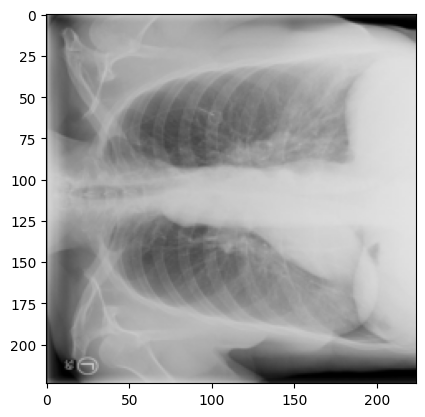

In [ ]:
plt.imshow(img.permute(2,1,0))

In [ ]:
img = img.to(device)

In [ ]:
img = img.unsqueeze(dim=0)

In [ ]:
model_s.eval()
with torch.no_grad():
  pred = model_s(img)

In [ ]:
pred.argmax(1)

tensor([1], device='cuda:0')